## Milling Tool Wear Maintenance Policy using the REINFORCE algorithm

- Ver. 4.1: 01-May-2023 - Improved plots
- Ver. 4.5: 01-May-2023 - Add Stable-Baselines algo.
- Ver. 4.6: 02-May-2023 - Expt RF vs SB-3 PPO, scaled rewards: 1/10^6 
- Ver. 4.8: 06-May-2023 - Auto run SB3 algos.
- Ver. 5.0: 06-May-2023 - Re-factor. Functions conversions to enable test runs.
- Ver. 5.1: 07-May-2023 - PPO behaviour. For SB-3 models, correct test set reshuffle and retraining of models everytime 
- Ver. 5.2: 07-May-2023 - Test cases sample 40 (constant) and _without_ replacement
- Ver. 5.3: 08-May-2023 - Do not sort Test cases. Possible cause of trends in ppo?
- Ver. 6.0: 08-May-2023 - Train once, save model, test multiple times. Block storing of model training progress
- Ver. 6.1: 08-May-2023 - Add pr., rc., f1 scores
- Ver. 6.2: 08-May-2023 - Fix div. by zero warnings
- Ver. 7.0: 09-May-2023 - Introduced two functions to compute algo. level aggregated metrics and save to a file
- Ver. 7.5: 10-May-2023 - Adapt for PHM data. Columns cloned in PHM original data: ```timestamp -> time,  tool_wear -> VB_mm, New added column -> ACTION_CODE```
- Ver. 8.0: 10-May-2023 - PHM data - 3 tests

In [14]:
import numpy as np
import pandas as pd

import milling_tool_environment
import utilities
from milling_tool_environment import MillingTool_V2
from utilities import compute_metrics, compute_metrics_simple, write_metrics_report, store_results, plot_learning_curve, single_axes_plot
from utilities import two_axes_plot, two_variable_plot, plot_error_bounds, test_script, write_test_results, downsample
from reinforce_classes import PolicyNetwork, Agent

import datetime
dt = datetime.datetime.now()
dt_d = dt.strftime('%d-%b-%Y')
dt_t = dt.strftime('%H_%M_%S')

In [26]:
import importlib
importlib.reload(milling_tool_environment)
importlib.reload(utilities)

<module 'utilities' from 'D:\\Rajesh\\ResearchLab\\LG_\\utilities.py'>

In [16]:
# Version name: <Ver.No>_Sim_<N or W>NB_<episodes>_test-run
# Data Files: Simulated_Dasic_2006_Tool_Wear_Model. Threshold 3mm
# PHM:        PHM_C01_0p12_DS PHM_C04_0p10_DS PHM_C06_0p13_DS

DATA_FILE = 'PHM_C04_0p10_DS.csv'
WEAR_THRESHOLD = 0.1 # mm
VERSION = f'8_PHM_{WEAR_THRESHOLD}_High_NBD'

ENVIRONMENT_INFO = 'Simulated Dasic 2006. Simple, single-state (wear). No noise. No break-down.'
TEST_INFO = 'Sampled from training data'
EPISODES = 600 # Train for N episodes. # Suggested 600
TEST_CASES = 40
# Milling operation constants
WEAR_THRESHOLD_NORMALIZED = 0.0 # normalized to the max wear threshold
MILLING_OPERATIONS_MAX = 300 # Suggested 300
ADD_NOISE = 1e2 # 0 for no noise. Factor to apply on np.random.rand(). For e.g. 1e2 or 1e3 are factors for higher and lower noise. 
BREAKDOWN_CHANCE = 0.10 # Recommended: 0.05 = 5%

# Policy network learning parameters
gamma = 0.99
alpha = 0.01

PREFIX = f'results_plots/V_{VERSION}_Tool_Wear_{dt_d}_{dt_t}'
RESULTS_FILE = f'results_plots/V_{VERSION}_{dt_d}_{dt_t}_test_results.csv'
METRICS_FILE = f'results_plots/V_{VERSION}_{dt_d}_{dt_t}_metrics.csv'
RF_TRAINING_FILE = f'results_plots/V_{VERSION}_RF_training_{dt_d}_{dt_t}.csv'

print('\n -- Columns added to results file ', RESULTS_FILE)
results = ['Date', 'Time', 'Round', 'Environment', 'Training_data', 'Wear_Threshold', 'Test_data', 'Algorithm', 'Episodes', 'Normal_cases', 'Normal_error', 
           'Replace_cases', 'Replace_error', 'Overall_error', 
           'Wtd_Precision', 'Wtd_Recall', 'F1_Beta']
write_test_results(results, RESULTS_FILE)


 -- Columns added to results file  results_plots/V_8_PHM_0.1_High_NBD_11-May-2023_09_22_59_test_results.csv


In [17]:
# DOWN SAMPLE HIGH RES DATA
# DATA_FILE = 'PHM_Tool_Wear_Data_C06_0p13.csv'
# df = pd.read_csv(DATA_FILE)
# df_downsampled = downsample(DATA_FILE, 100)
# df_downsampled.to_csv('PHM_C06_0p13_DS.csv', index=False)
# df_downsampled.head()

Tool wear data imported (348 records). WEAR_THRESHOLD_NORMALIZED: 0.413 




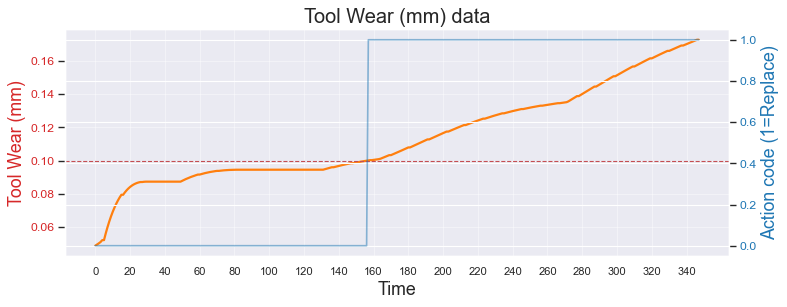

In [18]:
## Read data
df = pd.read_csv(DATA_FILE)
df = df[['time', 'VB_mm', 'ACTION_CODE']]

# Normalizing entire df with min-max scaling
WEAR_MIN = df['VB_mm'].min() 
WEAR_MAX = df['VB_mm'].max()
WEAR_THRESHOLD_NORMALIZED = (WEAR_THRESHOLD-WEAR_MIN)/(WEAR_MAX-WEAR_MIN)
df_normalized = (df-df.min())/(df.max()-df.min())
df_normalized['ACTION_CODE'] = df['ACTION_CODE']
print(f'Tool wear data imported ({len(df.index)} records). WEAR_THRESHOLD_NORMALIZED: {WEAR_THRESHOLD_NORMALIZED:4.3f} \n\n')

# Visualize the data
n_records = len(df.index)
x = [n for n in range(n_records)]
y1 = df['VB_mm'].values.tolist()
y2 = df['ACTION_CODE'].values.tolist()
two_axes_plot(x, y1, y2, title='Tool Wear (mm) data', x_label='Time', 
              y1_label='Tool Wear (mm)', y2_label='Action code (1=Replace)', xticks=20, threshold=WEAR_THRESHOLD)

## REINFORCE RL Algorithm

In [19]:
### Main loop
rewards_history = []
loss_history = []
training_stats = []

env = MillingTool_V2(df_normalized, WEAR_THRESHOLD_NORMALIZED, MILLING_OPERATIONS_MAX, ADD_NOISE, BREAKDOWN_CHANCE)

input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

agent_RF = Agent(input_dim, output_dim, alpha, gamma)

for episode in range(EPISODES):
    state = env.reset()

    # Sample a trajectory
    for t in range(MILLING_OPERATIONS_MAX): # Max. milling operations desired
        action = agent_RF.act(state)
        state, reward, done, info = env.step(action)
        agent_RF.rewards.append(reward)
        #env.render()
        if done:
            # print('** DONE **', info)
            break

    # Learn during this episode 
    loss = agent_RF.learn() # train per episode
    total_reward = sum(agent_RF.rewards)

    # Record statistics for this episode
    rewards_history.append(total_reward)
    loss_history.append(loss.item()) # Extract values from list of torch items for plotting

    # On-policy - so discard all data 
    agent_RF.onpolicy_reset()

    if (episode%100 ==0):
         print(f'[{episode:04d}] Loss: {loss:>10.2e} | Reward: {total_reward:>10.2e} | Ep.length: {env.ep_length:04d}')

[0000] Loss:  -1.36e+02 | Reward:  -2.38e+00 | Ep.length: 0300
[0100] Loss:  -4.71e+01 | Reward:  -1.05e+00 | Ep.length: 0300
[0200] Loss:   3.96e+00 | Reward:   1.47e+00 | Ep.length: 0251
[0300] Loss:   2.56e-01 | Reward:   5.96e-01 | Ep.length: 0153
[0400] Loss:   1.63e+00 | Reward:   7.09e-01 | Ep.length: 0187
[0500] Loss:   1.26e+01 | Reward:   2.31e+00 | Ep.length: 0300


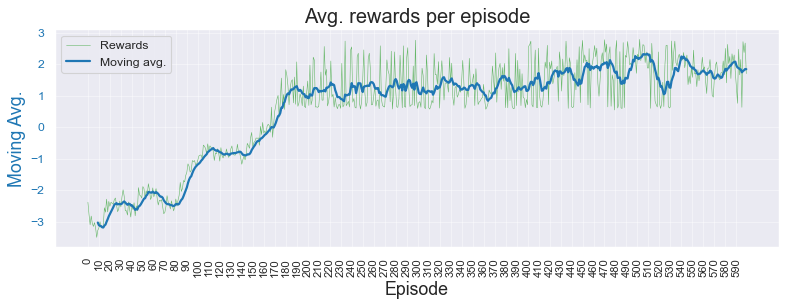

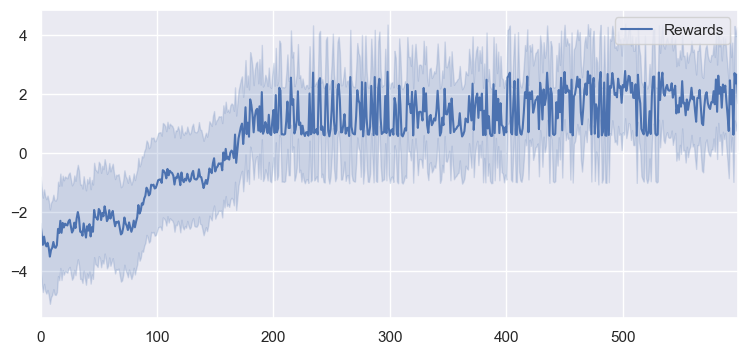

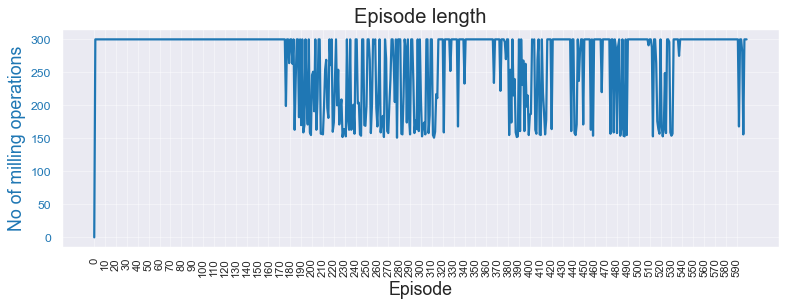

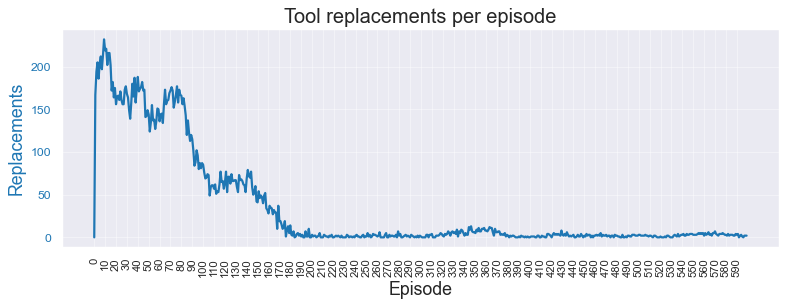

In [20]:
x = [i for i in range(EPISODES)]

## Moving average for rewards
ma_window_size = 10
# # Convert error array to pandas series
rewards = pd.Series(rewards_history)
windows = rewards.rolling(ma_window_size)
moving_avg = windows.mean()
moving_avg_lst = moving_avg.tolist()
y1 = rewards
y2 = moving_avg_lst

filename = PREFIX + '_Avg_episode_rewards.png'
two_variable_plot(x, y1, y2, 'Avg. rewards per episode', 'Episode', 'Avg. Rewards', 'Moving Avg.', 10, filename)

plot_error_bounds(x, y1)

filename = PREFIX + '_Episode_Length.png'
single_axes_plot(x, env.ep_length_history, 'Episode length', 'Episode', 'No of milling operations', 10, 0.0, filename)

filename = PREFIX + '_Tool_Replacements.png'
single_axes_plot(x, env.ep_tool_replaced_history, 'Tool replacements per episode', 'Episode', 'Replacements', 10, 0.0, filename)

In [21]:
# Process results
# eps = [i for i in range(EPISODES)]
# store_results(RF_TRAINING_FILE, training_round, eps, rewards_history, env.ep_tool_replaced_history)
print('\n === REINFORCE model trained ===\n')
for test_round in range(TEST_CASES):
    # Create test cases
    test_cases = np.random.choice(env.df_length-1, TEST_CASES, replace=False)
    results = test_script(test_round, df_normalized, 'REINFORCE', EPISODES, env, ENVIRONMENT_INFO, agent_RF, test_cases, TEST_INFO, DATA_FILE, WEAR_THRESHOLD, RESULTS_FILE)
    write_test_results(results, RESULTS_FILE)
    
print(f'\n- Test results written to file: {RESULTS_FILE}')


 === REINFORCE model trained ===

Algorithm	Normal	Error %	Replace	Error %	Overall error%
REINFORCE	19	0.000	21	0.905	0.475
--------------------------------------------------------------------------------
Algorithm	Normal	Error %	Replace	Error %	Overall error%
REINFORCE	18	0.000	22	0.864	0.475
--------------------------------------------------------------------------------
Algorithm	Normal	Error %	Replace	Error %	Overall error%
REINFORCE	20	0.000	20	0.850	0.425
--------------------------------------------------------------------------------
Algorithm	Normal	Error %	Replace	Error %	Overall error%
REINFORCE	16	0.000	24	0.875	0.525
--------------------------------------------------------------------------------
Algorithm	Normal	Error %	Replace	Error %	Overall error%
REINFORCE	14	0.000	26	1.000	0.650
--------------------------------------------------------------------------------
Algorithm	Normal	Error %	Replace	Error %	Overall error%
REINFORCE	18	0.000	22	0.818	0.450
--------------------

## Stable-Baselines Algorithms

In [22]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO, DQN

In [23]:
algos = ['A2C','DQN','PPO']
for SB_ALGO in algos:
    if SB_ALGO.upper() == 'A2C': agent_SB = A2C('MlpPolicy', env)
    if SB_ALGO.upper() == 'DQN': agent_SB = DQN('MlpPolicy', env)
    if SB_ALGO.upper() == 'PPO': agent_SB = PPO('MlpPolicy', env)

    env = MillingTool_V2(df_normalized, WEAR_THRESHOLD_NORMALIZED, MILLING_OPERATIONS_MAX, ADD_NOISE, BREAKDOWN_CHANCE)
    print(f'\n\n{SB_ALGO} - Training and Testing Stable-Baselines-3 {SB_ALGO} algorithm')
    agent_SB.learn(total_timesteps=EPISODES)
        
    for test_round in range(TEST_CASES):
        # Create test cases
        test_cases = np.random.choice(env.df_length-1, TEST_CASES, replace=False)
        results = test_script(test_round, df_normalized, SB_ALGO, EPISODES, env, ENVIRONMENT_INFO, agent_SB, test_cases, TEST_INFO, DATA_FILE, WEAR_THRESHOLD, RESULTS_FILE)
        write_test_results(results, RESULTS_FILE)
        



A2C - Training and Testing Stable-Baselines-3 A2C algorithm
Algorithm	Normal	Error %	Replace	Error %	Overall error%
A2C	20	0.350	20	0.950	0.650
--------------------------------------------------------------------------------
Algorithm	Normal	Error %	Replace	Error %	Overall error%
A2C	21	0.381	19	0.947	0.650
--------------------------------------------------------------------------------
Algorithm	Normal	Error %	Replace	Error %	Overall error%
A2C	20	0.300	20	0.900	0.600
--------------------------------------------------------------------------------
Algorithm	Normal	Error %	Replace	Error %	Overall error%
A2C	17	0.353	23	0.826	0.625
--------------------------------------------------------------------------------
Algorithm	Normal	Error %	Replace	Error %	Overall error%
A2C	23	0.391	17	0.882	0.600
--------------------------------------------------------------------------------
Algorithm	Normal	Error %	Replace	Error %	Overall error%
A2C	22	0.182	18	0.833	0.475
-----------------------------

### Create a consolidated algorithm wise metrics summary

In [24]:
print(80*'-', f'\n Algorithm level consolidated metrics being reported to file:\n {METRICS_FILE}\n', 80*'-')

header_columns = [VERSION]
write_test_results(header_columns, METRICS_FILE)
header_columns = ['Date', 'Time', 'Environment', 'Noise', 'Breakdown_chance', 'Train_data', 'Wear threshold','Episodes', 'Test_info', 'Test_cases']
write_test_results(header_columns, METRICS_FILE)

dt_t = dt.strftime('%H:%M:%S')
noise_info = 'None' if ADD_NOISE == 0 else (1/ADD_NOISE)
header_info = [dt_d, dt_t, ENVIRONMENT_INFO, noise_info, BREAKDOWN_CHANCE, DATA_FILE, WEAR_THRESHOLD, EPISODES, TEST_INFO, TEST_CASES]
write_test_results(header_info, METRICS_FILE)
write_test_results([], METRICS_FILE) # leave a blank line

print('- Experiment related meta info written')

df_algo_results = pd.read_csv(RESULTS_FILE)
algo_metrics = compute_metrics_simple(df_algo_results)
write_metrics_report(algo_metrics, METRICS_FILE, 4)
write_test_results([], METRICS_FILE) # leave a blank line
write_test_results([], METRICS_FILE) # leave a blank line
print('- Algorithm level consolidated metrics reported to file')

print('\n\n ================= END OF PROGRAM =================')

-------------------------------------------------------------------------------- 
 Algorithm level consolidated metrics being reported to file:
 results_plots/V_8_PHM_0.1_High_NBD_11-May-2023_09_22_59_metrics.csv
 --------------------------------------------------------------------------------
- Experiment related meta info written
- Algorithm level consolidated metrics reported to file


 ================= END OF PROGRAM =================


In [25]:
algo_metrics

,Wtd_Precision,Wtd_Recall,F1_Beta,Normal_error,Replace_error,Overall_error
,mean,mean,mean,mean,mean,mean
Algorithm,,,,,,
A2C,0.417092,0.42000,0.369984,0.276177,0.840902,0.58000
DQN,0.388840,0.45500,0.307683,0.026625,0.976286,0.54500
PPO,0.491050,0.44500,0.423928,0.331204,0.723082,0.55500
REINFORCE,0.638250,0.48625,0.365478,0.008550,0.915821,0.51375
